In [15]:
%matplotlib inline
import sys
import os
DATA_PATH = os.getenv('DATA_PATH')
CODE_PATH = os.getenv('CODE_PATH')
FIGURE_PATH = os.getenv('FIGURE_PATH')

sys.path.insert(0, os.path.join(CODE_PATH))

import pandas as pd
import numpy as np
import json
import re

import time

from src.load import EGRID, BA_DATA

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from calendar import month_abbr

import logging.config
logging.config.fileConfig(os.path.join(CODE_PATH, "src/logging.conf"))
logger = logging.getLogger(__name__)
                           
COLORS = sns.color_palette('muted')

In [16]:
plt.style.use('seaborn-paper')
plt.rcParams['figure.figsize'] = [6.99, 2.5]
plt.rcParams['grid.color'] = 'k'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams["figure.dpi"] = 200
plt.rcParams["figure.dpi"] = 200
plt.rcParams['font.size'] = 10

import cmocean
cmap = cmocean.cm.cmap_d['phase']

In [17]:
co2 = BA_DATA(fileNm=os.path.join(DATA_PATH, "analysis/SEED_CO2_H.csv"), variable="CO2")
elec = BA_DATA(fileNm=os.path.join(DATA_PATH, "analysis/SEED_E_H.csv"), variable="E")
co2i = BA_DATA(fileNm=os.path.join(DATA_PATH, "analysis/SEED_EFs_CO2_H.csv"), variable="CO2i")

In [18]:
# Make sure directory exists
os.makedirs(os.path.join(FIGURE_PATH, "si", "daily_profiles"), exist_ok=True)

# Version 1

In [19]:
# Load gen mixes
egrid = EGRID()
df_mix = egrid.df[["BACODE"]+[col for col in egrid.df.columns if "PR" in col]]
df_mix.set_index("BACODE", inplace=True)

2019-11-16 19:42:36,073 - load - INFO - Loading EGRID sheet BA16


In [20]:
df_mix.head()

,BACLPR,BAOLPR,BAGSPR,BANCPR,BAHYPR,BABMPR,BAWIPR,BASOPR,BAGTPR,BAOFPR,BAOPPR,BATNPR,BATRPR,BATHPR,BACYPR,BACNPR
BACODE,,,,,,,,,,,,,,,,
YAD,0.000000,0.000000,0.000000,0.0,100.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,100.000000,0.000000,0.000000,100.000000
AMPL,0.000000,0.018525,84.147133,0.0,10.197653,5.636690,0.000000,0.000000,0.0,0.0,0.0,84.165657,15.834343,5.636690,89.802347,10.197653
AZPS,62.844558,0.030247,21.587496,0.0,0.000000,1.454381,2.465901,11.617416,0.0,0.0,0.0,84.462301,15.537699,15.537699,85.916683,14.083317
DEAA,0.000000,0.000000,100.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,100.000000,0.000000,0.000000,100.000000,0.000000
AECI,64.988974,0.057513,28.172908,0.0,0.401885,0.052681,6.326039,0.000000,0.0,0.0,0.0,93.219395,6.780605,6.378720,93.272076,6.727924


In [21]:
Pacific = -7
Mountain = -6
Arizona = -6
Eastern = -4
Central = -5
ba_dict = {"CISO":Pacific, "BPAT":Pacific, "NWMT":Mountain,
           "MISO":Eastern, "PJM":Eastern, "AZPS":Arizona,
           "ERCO":Central, "SWPP":Central, "PACW":Pacific,
           "SOCO":Central, "NYIS":Eastern, "ISNE":Eastern,
           "FPL":Eastern, "ERCO":Central, "TVA":Central,
           "DUK":Eastern, "CPLE":Eastern, "WACM":Arizona,
           "FPC":Eastern, "PSCO":Mountain, "PACE":Mountain,
           "SRP":Arizona, "WWA":Mountain, "GWA":Mountain,
           "PSEI":Pacific, "IPCO":Pacific, "SPA":Central,
           "OVEC":Eastern, "NEVP":Pacific, "BANC":Pacific,
           "LDWP":Pacific, "PNM":Arizona}

In [22]:
col_name_map = dict(zip(
        ["coal", "oil", "gas", "nuclear", "hydro", "biomass", "wind", "solar", "geothermal", "other fossil", "other"],
        ["BACLPR", "BAOLPR", "BAGSPR", "BANCPR", "BAHYPR", "BABMPR", "BAWIPR", "BASOPR", "BAGTPR", "BAOFPR", "BAOPPR"]))
pie_colors = dict(zip(
        ["hydro", "solar", "biomass", "nuclear", "gas", "oil", "geothermal", "coal", "other fossil", "wind", "other"],
        COLORS + COLORS[8:9]))


In [23]:
def dailyProfiles(ba_list=["PJM", "MISO", "CISO", "BPAT"], saveNm="si/daily_profiles/daily_profiles",
                  ymax_co2i=800, wleg=True, verb=False):
    genmixes = {ba:{k:df_mix.loc[ba, col_name_map[k]] for k in pie_colors.keys()
                     if df_mix.loc[ba, col_name_map[k]]>1.} for ba in ba_list}
    if verb:
        import pprint
        pp = pprint.PrettyPrinter(indent=2)
        pp.pprint(genmixes)


    months = list(range(1,13))
    selected_months = [1,3,5,7,9,11]
    x = np.linspace(0.0, 1.0, len(selected_months))
    cm_colors = cmap(x)[np.newaxis, :, :3][0]

    cm_colors = sns.color_palette("husl", len(selected_months))

    f, (elec_ax, co2i_ax) = plt.subplots(2,4, figsize=(7.4, 3))
    for iba, ba in enumerate(ba_list):
        df_plot = elec.df.loc[:,elec.get_cols(ba, field="D")].copy(deep=True)
        df_plot2 = co2i.df.loc[:, co2i.get_cols(ba, field="D")].copy(deep=True)

        utc_offset = ba_dict[ba]

        df_plot.index += pd.Timedelta('%dh' % utc_offset)
        df_plot["MONTH"] = df_plot.index.month
        df_plot["HOUR"] = df_plot.index.hour
        df_plot2.index += pd.Timedelta('%dh' % utc_offset)
        df_plot2["MONTH"] = df_plot2.index.month
        df_plot2["HOUR"] = df_plot2.index.hour

        grp_c_e = df_plot.loc[:,elec.get_cols(ba, field="D") + ["MONTH", "HOUR"]].groupby(["MONTH", "HOUR"]).median()

        grp_ci = df_plot2.loc[:,co2i.get_cols(ba, field="D") + ["MONTH", "HOUR"]].groupby(["MONTH", "HOUR"]).median()



        label = '_nolegend_'
        for im, m in enumerate(selected_months):
            if iba == 3:
                label = month_abbr[m]
            elec_ax[iba].plot(grp_c_e.loc[m, elec.get_cols(ba, field="D")]/1e3, label='_nolegend_', color=cm_colors[im], lw=1)
            co2i_ax[iba].plot(grp_ci.loc[m, co2i.get_cols(ba, field="D")], label=label, color=cm_colors[im], lw=1)

        elec_ax[iba].set_xlim([0,23])
        elec_ax[iba].set_ylim(bottom=0,
                             top=elec_ax[iba].get_ylim()[1]*1.05)
        elec_ax[iba].tick_params(pad=2, direction='in')
        elec_ax[iba].set_title(ba)

        co2i_ax[iba].set_xlim([0,23])
        co2i_ax[iba].set_xlabel('hour')
        co2i_ax[iba].set_ylim(bottom=0, top=ymax_co2i)
        co2i_ax[iba].tick_params(pad=2, direction='in')



    for ax, ba in zip(elec_ax, ba_list):
        axins = inset_axes(ax, width="100%", height="100%",
                           bbox_to_anchor=(0.3, .05, .6, .6),
                           bbox_transform=ax.transAxes)
        axins.pie(genmixes[ba].values(), colors=[pie_colors[k] for k in genmixes[ba].keys()])

    for lab in ["coal", "oil", "gas", "nuclear", "hydro", "wind", "solar", "biomass", "geothermal"]:
        elec_ax[3].plot([], [], color=pie_colors[lab], label=lab, marker='s', linestyle="")

    elec_ax[0].set_ylabel('GWh')
    co2i_ax[0].set_ylabel('kg/MWh')
    #co2i_ax[2].legend(loc='lower center', bbox_to_anchor=(0., -0.6), ncol=1)
    if wleg:
        co2i_ax[3].legend(loc='lower center', bbox_to_anchor=(1.5, -0.1), ncol=1)
        elec_ax[3].legend(loc='lower center', bbox_to_anchor=(1.5, -0.3), ncol=1)

    plt.savefig(os.path.join(FIGURE_PATH, '%s.pdf' % saveNm), bbox_inches='tight')
#     plt.savefig(os.path.join(FIGURE_PATH, '%s.png' % saveNm), bbox_inches='tight')

{ 'BPAT': { 'biomass': 1.27177377292222,
            'coal': 5.34684287834561,
            'gas': 11.0127339919899,
            'hydro': 64.2877385896556,
            'nuclear': 7.91803932332085,
            'wind': 10.0791287053916},
  'CISO': { 'biomass': 3.2169754355184,
            'gas': 47.2386276038963,
            'geothermal': 4.92403660136224,
            'hydro': 12.6721740336701,
            'nuclear': 11.2007928382465,
            'solar': 11.9185608877211,
            'wind': 7.879623884127},
  'MISO': { 'biomass': 1.83780504308299,
            'coal': 44.7208385083111,
            'gas': 27.8793232898285,
            'hydro': 1.39347120906003,
            'nuclear': 14.6697705469512,
            'oil': 1.15102237653347,
            'wind': 7.12021998969011},
  'PJM': { 'biomass': 1.53842718811011,
           'coal': 32.7337399261915,
           'gas': 26.7037663001567,
           'nuclear': 34.9358970282412,
           'wind': 2.36989246083933}}


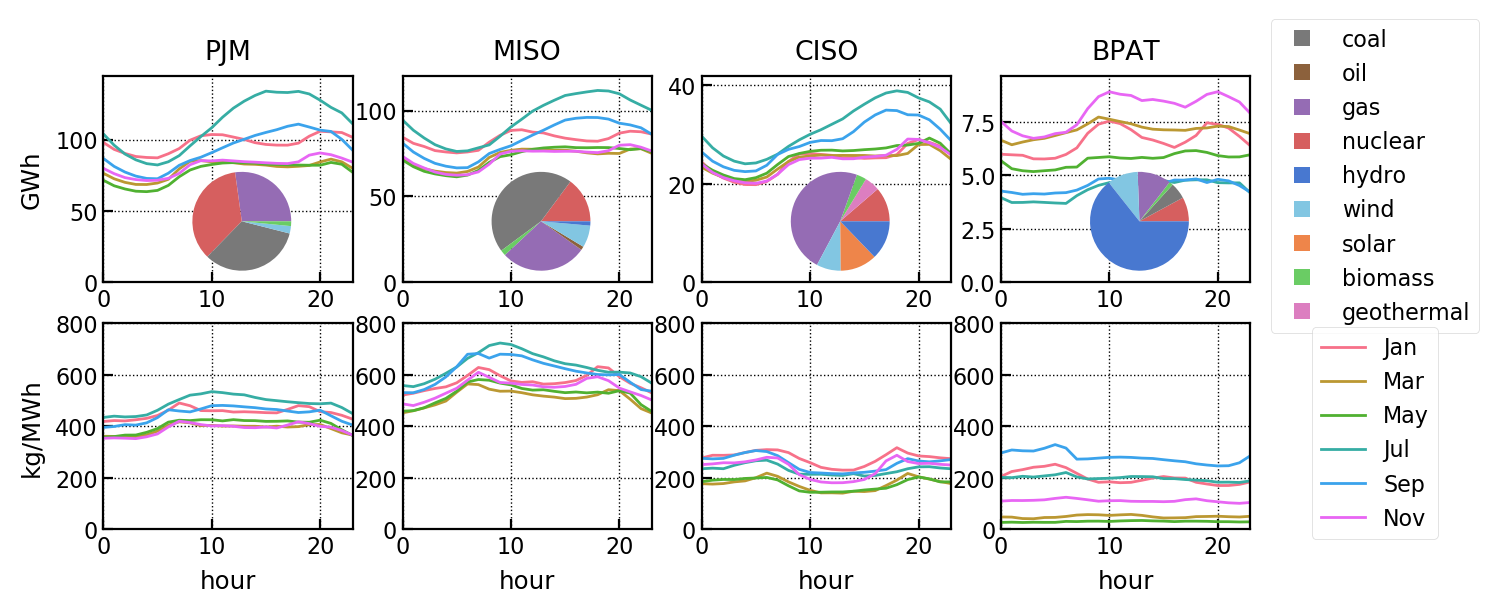

In [24]:
dailyProfiles(verb=True)

# More BAs - SI

In [25]:
def helper(elec_ax, co2i_ax, ba_list, ymax_co2i):
    genmixes = {ba:{k:df_mix.loc[ba, col_name_map[k]] for k in pie_colors.keys()
                     if df_mix.loc[ba, col_name_map[k]]>1.} for ba in ba_list}
    
    
    months = list(range(1,13))
    selected_months = [1,3,5,7,9,11]
    x = np.linspace(0.0, 1.0, len(selected_months))
    cm_colors = cmap(x)[np.newaxis, :, :3][0]

    cm_colors = sns.color_palette("husl", len(selected_months))
    
    for iba, ba in enumerate(ba_list):
        df_plot = elec.df.loc[:,elec.get_cols(ba, field="D")].copy(deep=True)
        df_plot2 = co2i.df.loc[:, co2i.get_cols(ba, field="D")].copy(deep=True)

        utc_offset = ba_dict[ba]

        df_plot.index += pd.Timedelta('%dh' % utc_offset)
        df_plot["MONTH"] = df_plot.index.month
        df_plot["HOUR"] = df_plot.index.hour
        df_plot2.index += pd.Timedelta('%dh' % utc_offset)
        df_plot2["MONTH"] = df_plot2.index.month
        df_plot2["HOUR"] = df_plot2.index.hour

        grp_c_e = df_plot.loc[:,elec.get_cols(ba, field="D") + ["MONTH", "HOUR"]].groupby(["MONTH", "HOUR"]).median()

        grp_ci = df_plot2.loc[:,co2i.get_cols(ba, field="D") + ["MONTH", "HOUR"]].groupby(["MONTH", "HOUR"]).median()



        label = '_nolegend_'
        for im, m in enumerate(selected_months):
            if iba == 3:
                label = month_abbr[m]
            elec_ax[iba].plot(grp_c_e.loc[m, elec.get_cols(ba, field="D")]/1e3, label='_nolegend_', color=cm_colors[im], lw=1)
            co2i_ax[iba].plot(grp_ci.loc[m, co2i.get_cols(ba, field="D")], label=label, color=cm_colors[im], lw=1)

        elec_ax[iba].set_xlim([0,23])
        elec_ax[iba].set_ylim(bottom=0,
                             top=elec_ax[iba].get_ylim()[1]*1.05)
        elec_ax[iba].tick_params(pad=2, direction='in')
        elec_ax[iba].set_title(ba)

        co2i_ax[iba].set_xlim([0,23])
        co2i_ax[iba].set_xlabel('hour')
        co2i_ax[iba].set_ylim(bottom=0, top=ymax_co2i)
        co2i_ax[iba].tick_params(pad=2, direction='in')



    for ax, ba in zip(elec_ax, ba_list):
        axins = inset_axes(ax, width="100%", height="100%",
                           bbox_to_anchor=(0.3, .05, .6, .6),
                           bbox_transform=ax.transAxes)
        axins.pie(genmixes[ba].values(), colors=[pie_colors[k] for k in genmixes[ba].keys()])

    for lab in ["coal", "oil", "gas", "nuclear", "hydro", "wind", "solar", "biomass", "geothermal"]:
        elec_ax[3].plot([], [], color=pie_colors[lab], label=lab, marker='s', linestyle="")

    elec_ax[0].set_ylabel('GWh')
    co2i_ax[0].set_ylabel('kg/MWh')
    


def dailyProfiles_si(ba_list, ymax_co2i=[800, 800, 800], saveNm='test'):
    months = list(range(1,13))
    selected_months = [1,3,5,7,9,11]
    x = np.linspace(0.0, 1.0, len(selected_months))
    cm_colors = cmap(x)[np.newaxis, :, :3][0]

    cm_colors = sns.color_palette("husl", len(selected_months))

    nrows = 6
    ncols = 4

    #f, axes = plt.subplots(3*2, 4, figsize=(7.4, nrows*3))

    fig, ax = plt.subplots(figsize=(7.4, 3*3))
    plt.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.01)

    ax.xaxis.set_ticklabels([])
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticklabels([])
    ax.yaxis.set_ticks([])

    # These are in unitless percentages of the figure size. (0,0 is bottom left)
    #left, bottom, width, height = 

    width = 0.7/4
    height = 0.65/6
    left = 0.1
    bottom = 0.11
    wspace = 0.05
    hspace1 = 0.02
    hspace2 = 0.07

    axes = []

    totalhspace = nrows/2 * (hspace2 + hspace1)
    for r in range(nrows):
        axes.append([])
        hspace = hspace1
        if r%2 == 0:
            hspace = hspace2
        totalhspace -= hspace
        for c in range(ncols):
            axes[r].append(fig.add_axes(
                    [left + c*(width+wspace),
                     bottom + (nrows-r-1)*height + totalhspace,
                     width, height])) 

    for i in range(0,nrows,2):
        helper(axes[i], axes[i+1], ba_list[i//2], ymax_co2i[i//2])

    axes[4][3].legend(loc='lower center', bbox_to_anchor=(-2.5, -2.05), ncol=5)
    axes[5][3].legend(loc='lower center', bbox_to_anchor=(0.2, -.85), ncol=3)

    plt.savefig(os.path.join(FIGURE_PATH, '%s.pdf' % saveNm))

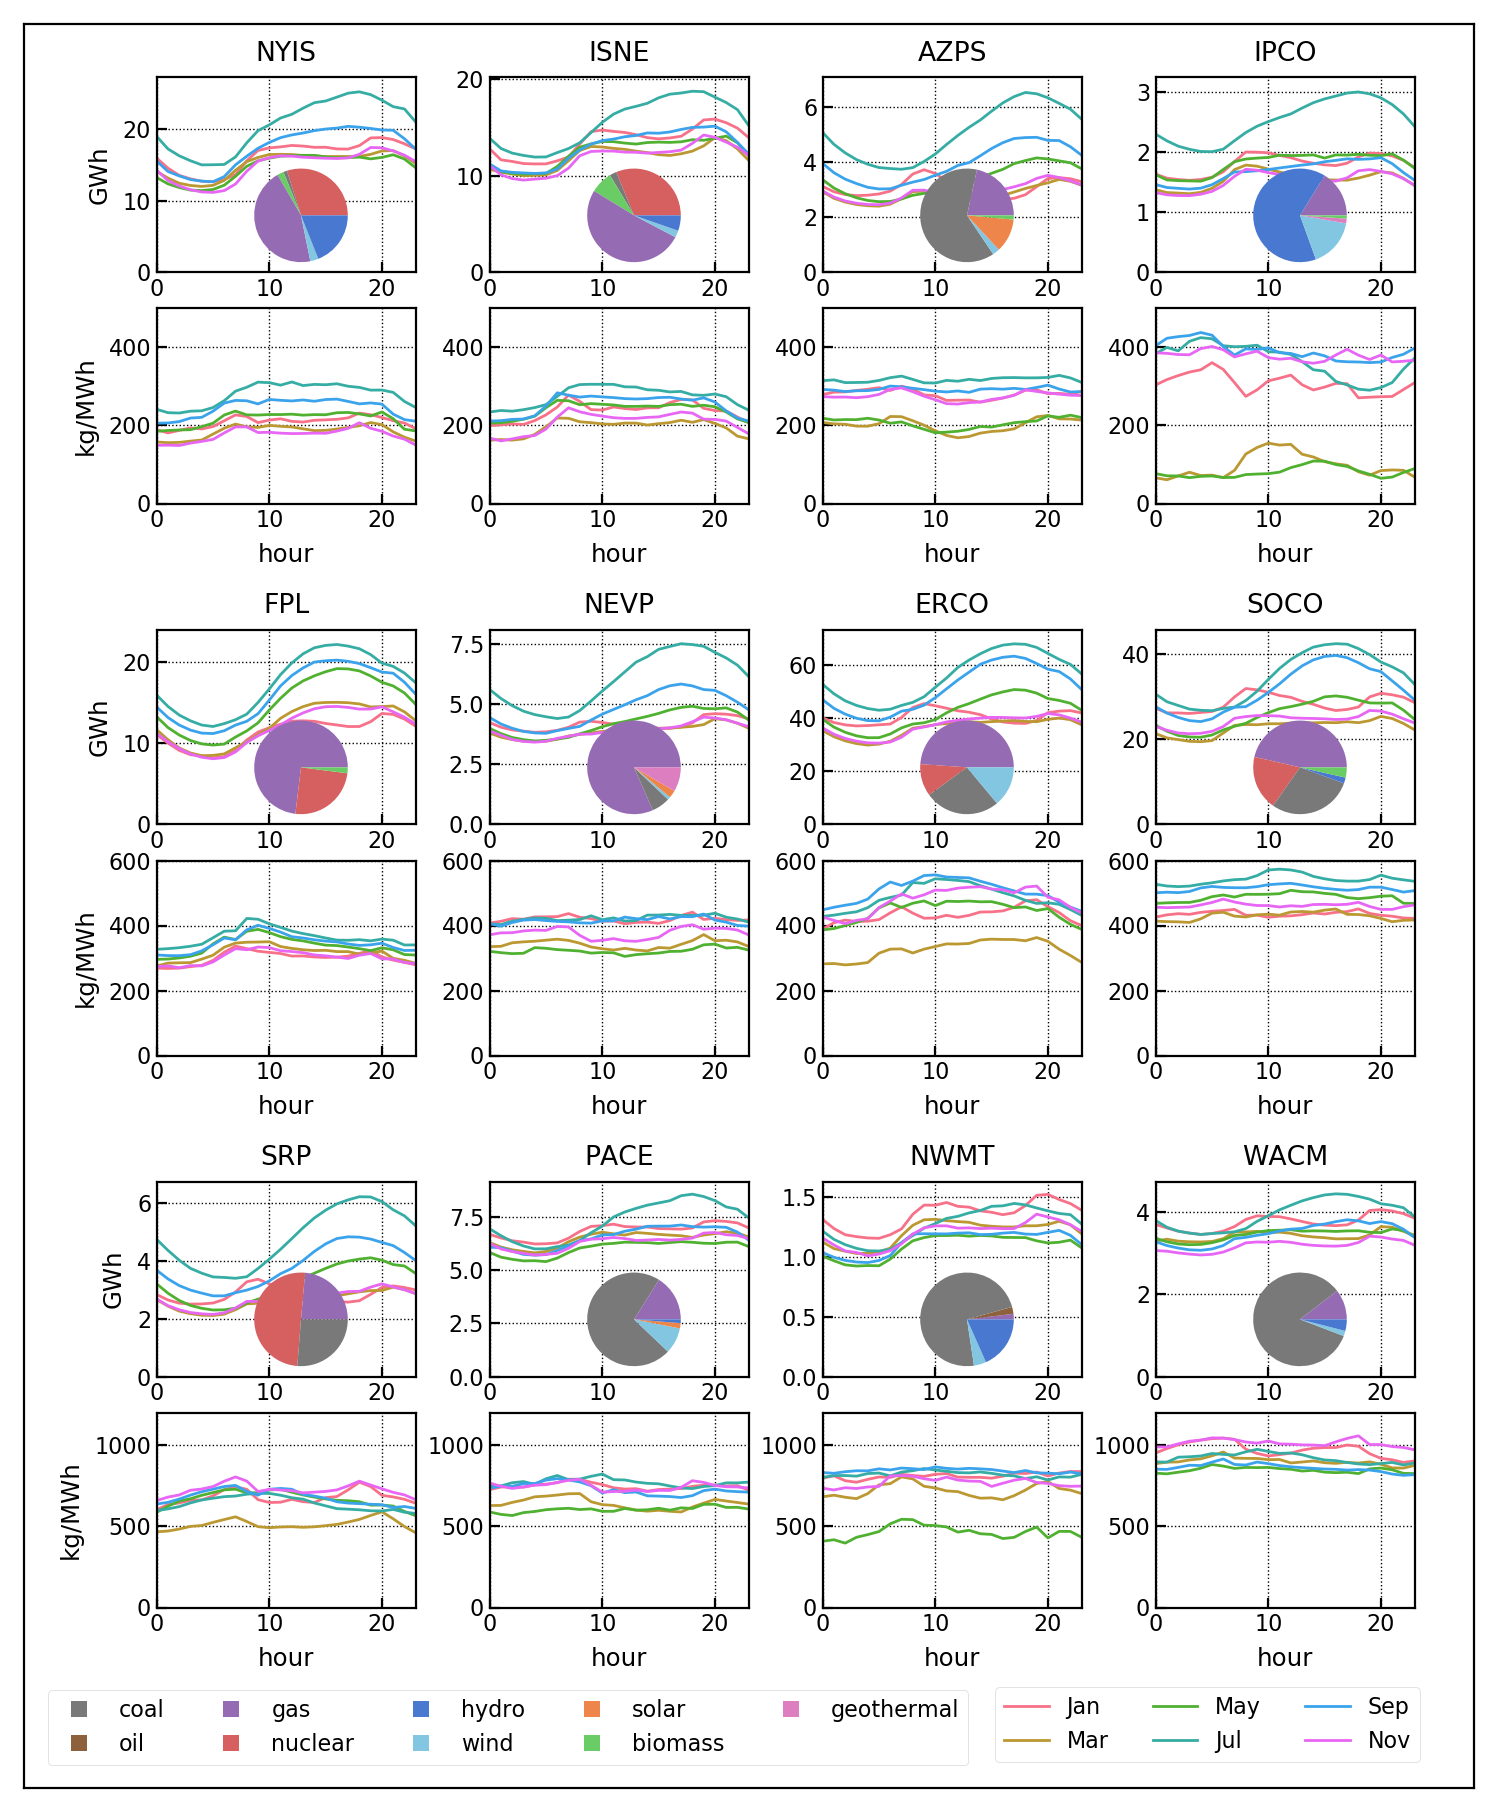

In [26]:
ba_list = [
    ["NYIS", "ISNE", "AZPS", "IPCO"],
    ["FPL", "NEVP", "ERCO", "SOCO"],
    ["SRP", "PACE", "NWMT", "WACM"]]
dailyProfiles_si(ba_list, [500, 600, 1200],
                 saveNm="si/daily_profiles/daily_profiles1")

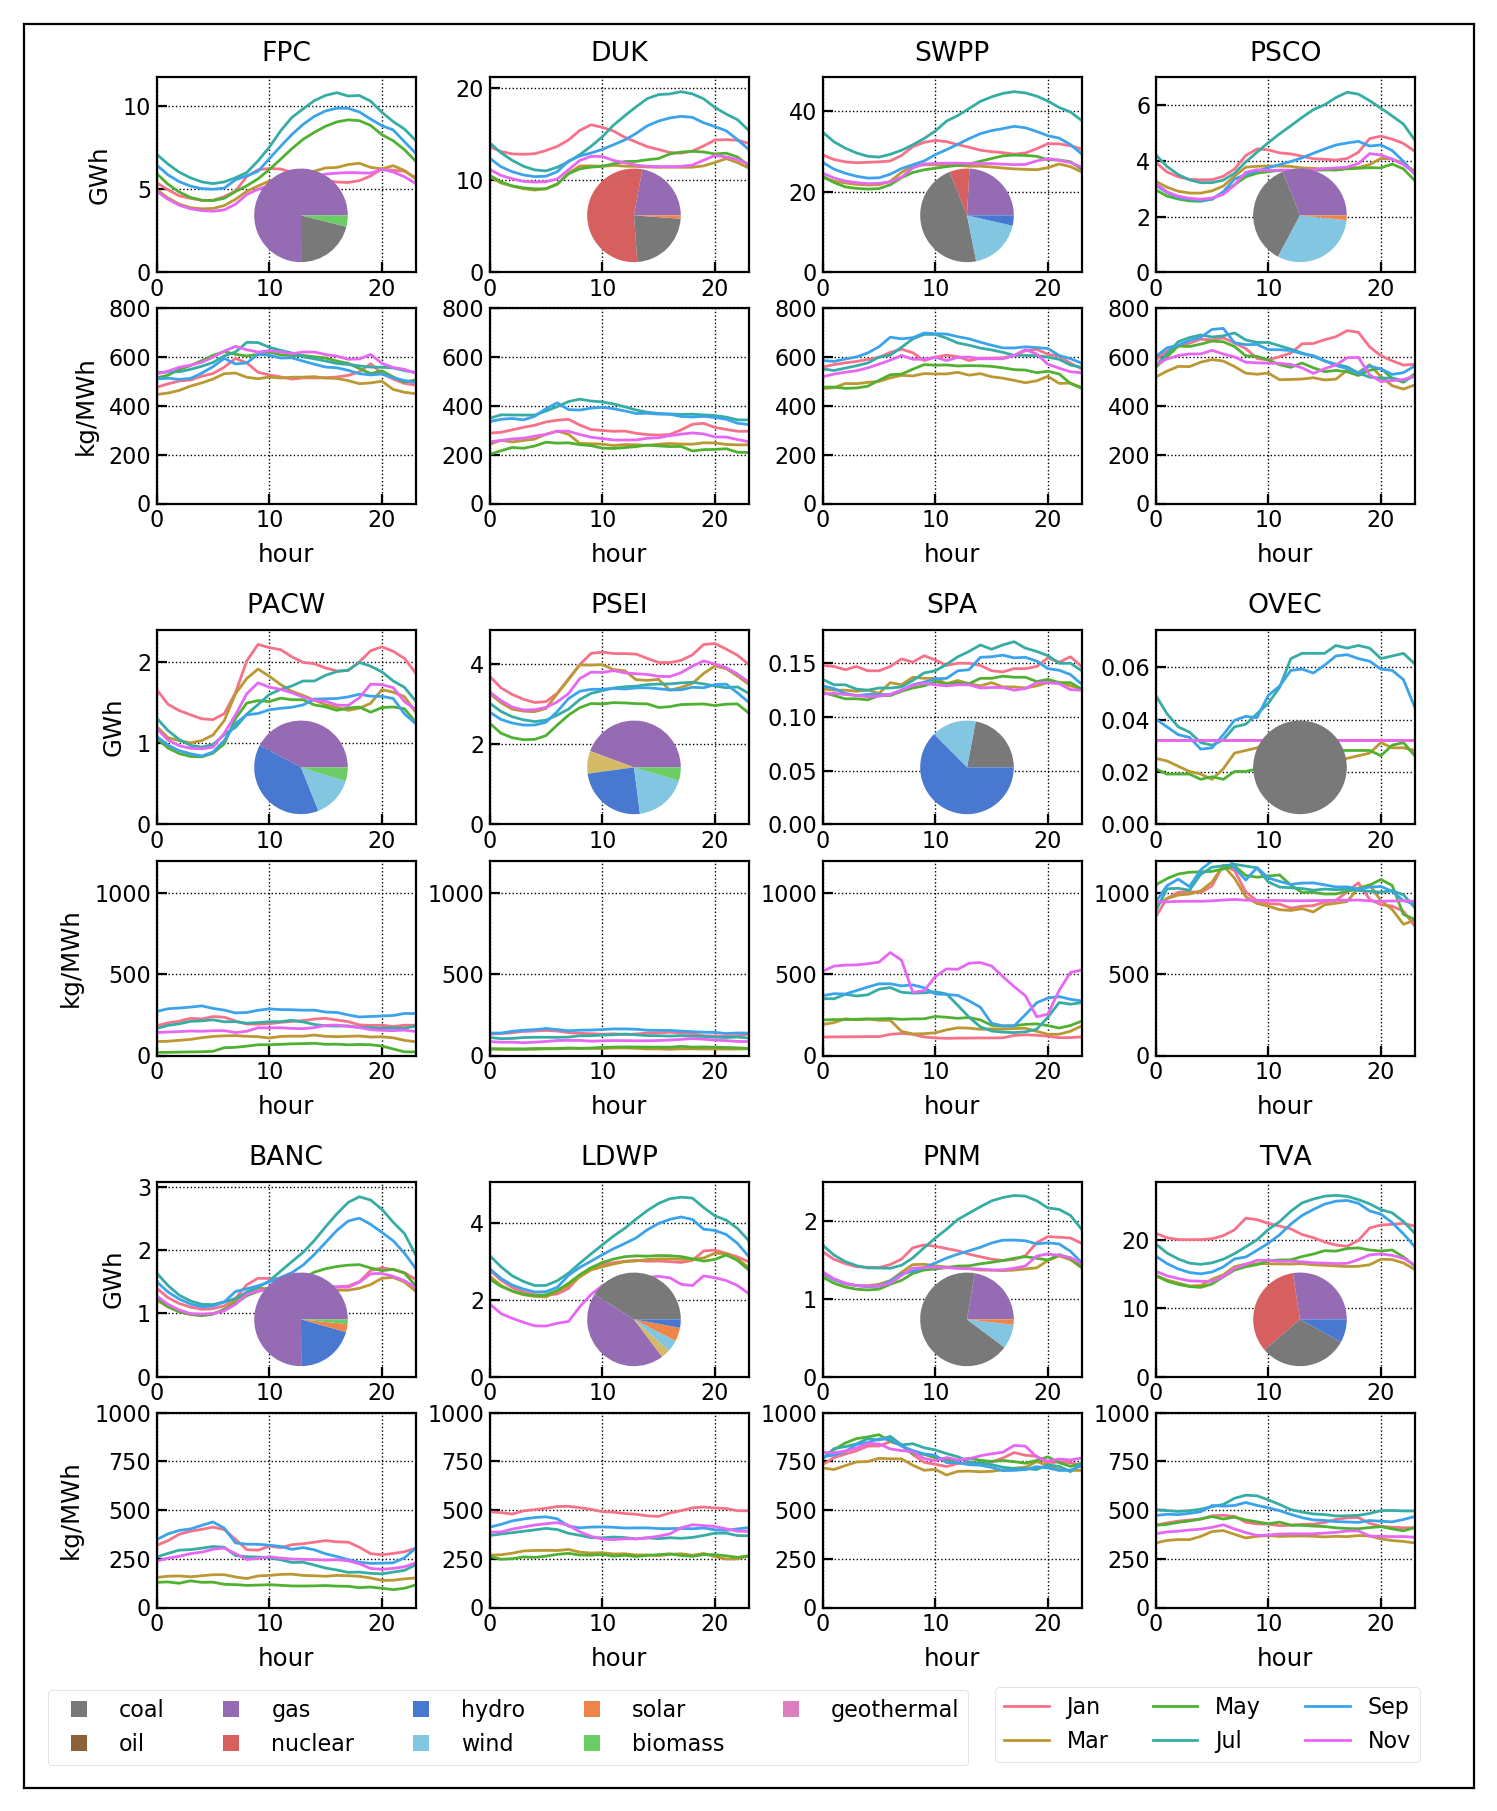

In [27]:
ba_list = [
    ["FPC", "DUK", "SWPP", "PSCO"],
    ["PACW", "PSEI", "SPA", "OVEC"],
    ["BANC", "LDWP", "PNM", "TVA"]]
dailyProfiles_si(ba_list, [800, 1200, 1000],
                 "si/daily_profiles/daily_profiles2")

In [28]:
# Create SI text
figtex = r'''\begin{figure*}%[tbhp]
\centering
\includegraphics[width=17.79cm]{figures/daily_profiles/daily_profiles'''
figtex2 = r'''.pdf}
\label{fig:daily_profiles'''

figtex3='''}
\caption{Daily profiles (median values for different months and hours of the day, using local time zones) for selected balancing authorities. Top: median electricity consumption and 2016 grid generation mix (excluding imports). Bottom: median carbon intensity of consumption.}
\end{figure*}'''

with open(os.path.join(FIGURE_PATH, "si/daily_profiles/daily_profiles.tex"), "w") as fw:
     for i in range(1,3):
            fw.write(figtex+str(i)+figtex2+str(i)+figtex3+"\n")